# Generate Images from demo RealisticRendering

This ipython notebook can be found in [client/examples/generate-images.ipynb](https://github.com/qiuwch/unrealcv/blob/master/client/examples/generate-images.ipynb). Before you start, please read the [Tutorial: Getting Started](http://unrealcv.github.io/tutorial/getting_started.html) first.

First, we need to load some python libraries for this tutorial.

In [41]:
import os, sys, time, re, json
import numpy as np
# from scipy import misc # for imread
# imread = misc.imread # use this instead of the imread in matplotlib
import cv2
imread = lambda x: cv2.imread(x)[:,:,(2,1,0)]

# Load matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Connect to the game

In [42]:
# Load unrealcv python client, do `pip install unrealcv` first.
from unrealcv import client
client.connect()
if not client.isconnected():
    print 'UnrealCV server is not running. Run the game downloaded from http://unrealcv.github.io first.'

In [43]:
# You can use this to show help message of a function
# client?
# client.request?

In [44]:
# Test connection
res = client.request('vget /unrealcv/status')
print res

Is Listening
Client Connected
9000



## Read a camera trajectory from a file

We will read a camera trajectory from `camera_traj.json`. This file contains a camera trajectory with 10 frames. The camera trajectory recorded using another python script.

In [45]:
!head -n 13 ./camera_traj.json

[
  [
    {
      "y": 0.0,
      "x": 0.0,
      "z": 136.335
    },
    {
      "yaw": 297.717,
      "roll": 0.0,
      "pitch": 341.382
    }
  ],


In [46]:
import json
camera_trajectory = json.load(open('camera_traj.json'))
print camera_trajectory[0] # camera location and rotation

[{u'y': 0.0, u'x': 0.0, u'z': 136.335}, {u'yaw': 297.717, u'roll': 0.0, u'pitch': 341.382}]


## Render images using the camera trajectory

Define a function to render an image and its annotation

In [47]:
def render_frame(client, cam_pose=None):
    ''' If you want to render a frame using current camera position, leave the pos argument to None '''
    if cam_pose is not None:
        (loc, rot) = cam_pose
        res = client.request('vset /camera/0/location {x} {y} {z}'.format(**loc))
        assert res == 'ok', 'Fail to set camera location'
        res = client.request('vset /camera/0/rotation {pitch} {yaw} {roll}'.format(**rot))
        assert res == 'ok', 'Fail to set camera rotation'

    f = dict(
        lit = client.request('vget /camera/0/lit'),
        depth = client.request('vget /camera/0/depth depth.exr'), # The depth is saved as HDR image
        object_mask = client.request('vget /camera/0/object_mask'),
        normal = client.request('vget /camera/0/normal'),
    )
    return f


Define a utility function for plotting rendered images

In [48]:
def subplot_image(sub_index, image, param=None):
    if isinstance(image, str):
        image = imread(image)
    plt.subplot(sub_index)
    plt.imshow(image, param)
    plt.axis('off')

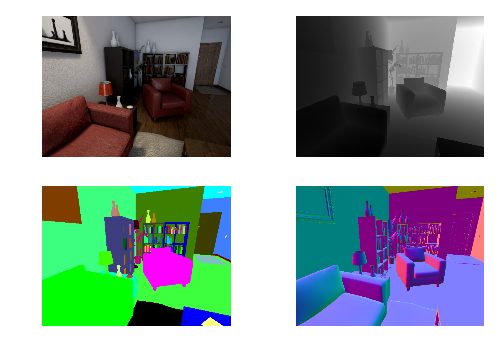

In [50]:
pos = camera_trajectory[1]
frame = render_frame(client, pos)

# plt.rcParams['figure.figsize'] = (10.0, 7.0) # (w, h)
subplot_image(221, frame['lit'])
subplot_image(223, frame['object_mask'])
subplot_image(224, frame['normal'])

# depth is saved as HDR image and requires special care.
depth = cv2.imread(frame['depth'], cv2.IMREAD_ANYDEPTH)
subplot_image(222, depth, 'gray')

# for demostration purpose, we just render one frame. If you want to generate all frames of the trajectory
# simply do frames = [render_frame(client, pos) for pos in camera_trajectory]

## Parse the object instance mask
Notice: this is a slow and very inefficient implementation. we are working on improving it.
If you have suggestion about how to improve, please contact Weichao Qiu (qiuwch@gmail.com)

Here we have the a color map of object instance, then we need to know the color for each object


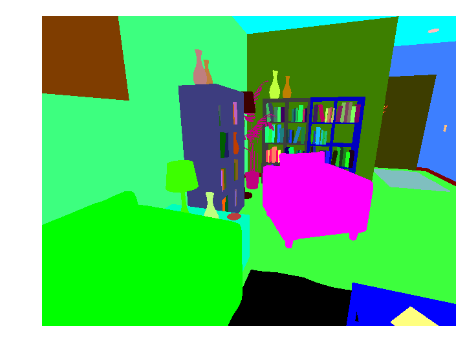

In [51]:
subplot_image(111, frame['object_mask'])

print '''Here we have the a color map of object instance, then we need to know the color for each object''' 

In [52]:
# Get a list of all objects in the scene
scene_objects = client.request('vget /objects').split(' ')
print 'There are %d objects in this scene' % len(scene_objects)

There are 295 objects in this scene


In [53]:
class Color(object):
    ''' A utility class to parse color value '''
    regexp = re.compile('\(R=(.*),G=(.*),B=(.*),A=(.*)\)')
    def __init__(self, color_str):
        self.color_str = color_str
        match = self.regexp.match(color_str)
        (self.R, self.G, self.B, self.A) = [int(match.group(i)) for i in range(1,5)]

    def __repr__(self):
        return self.color_str

def subplot_color(index, color, title):
    plt.subplot(index)
    im = np.zeros((100, 100, 4))
    # red = np.array([1.0, 0, 0, 1.0])
    color_array = np.array([color.R, color.G, color.B, color.A]) / 255.0 # repmat
    im = im + color_array
    print title, color
    plt.imshow(im)
    plt.axis('off')
    plt.title(title)


If we want to know the color of a specific object, we can use command `vget /object/[str]/color`. `[str]` is the object name. We first iterate all objects of the scene and get their color.

In [54]:
def get_color_mapping(client, object_list):
    ''' Get the color mapping for specified objects '''
    color_mapping = {}
    for objname in object_list:
        color_mapping[objname] = Color(client.request('vget /object/%s/color' % objname))
    return color_mapping


WallPiece1_22 (R=63,G=255,B=127,A=255)
SM_Shelving_6 (R=63,G=63,B=127,A=255)
SM_Couch_1seat_5 (R=255,G=0,B=255,A=255)
SM_Frame_39 (R=127,G=63,B=0,A=255)


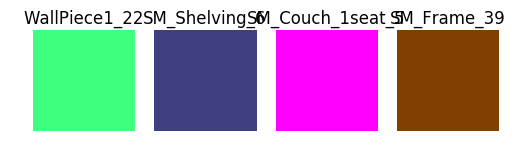

In [16]:
# Plot the annotation color for some objects. This cell might take about one minute
color_mapping = get_color_mapping(client, scene_objects)
selected_objects = ['WallPiece1_22', 'SM_Shelving_6', 'SM_Couch_1seat_5', 'SM_Frame_39']

baseindex = 100 + 10 * len(selected_objects) + 1
for i in range(len(selected_objects)):
    object_name = selected_objects[i]
    color = color_mapping[object_name]
    subplot_color(baseindex+i, color, object_name)

Given we know the labeling color for each object, we can compute the object instance mask for each object.

In [17]:
def match_color(color_image, target_color, tolerance=3): # Tolerance is used to solve numerical issue
    match_region = np.ones(color_image.shape[0:2], dtype=bool)
    for c in range(3): # Iterate over three channels
        min_val = target_color[c]-tolerance; max_val = target_color[c]+tolerance
        channel_region = (color_image[:,:,c] >= min_val) & (color_image[:,:,c] <= max_val)
        # channel_region = color_image[:,:,c] == target_color[c]
        match_region &= channel_region
    return match_region

def compute_instance_mask(object_mask, color_mapping, objects):
    if isinstance(object_mask, str):
        object_mask = imread(object_mask)

    dic_instance_mask = {}
    for object_name in objects:
        color = color_mapping[object_name]
        region = match_color(object_mask, [color.R, color.G, color.B], tolerance=3)
        if region.sum() != 0: # Present in the image
            dic_instance_mask[object_name] = region
    return dic_instance_mask


In [18]:
# Compute the binary mask for each object instance
dic_instance_mask = compute_instance_mask(frame['object_mask'], color_mapping, scene_objects)
# dic_instance_mask[object_name] can return the binary mask of the object

In [19]:
# Do some correctness test
import ipynb_util
reload(ipynb_util)
from ipynb_util import check_coverage
covered = check_coverage(dic_instance_mask)
# plt.imshow(covered)

Coverage 1.00


In [20]:
def plot_image_with_mask(image, mask):
    '''
    Mask is a binary matrix, only mask==1 will be plotted
    '''
    if isinstance(image, str):
        image = imread(image)
    subplot_image(121, image)
    masked_image = image.copy()
    masked_image[~mask] = 0
    subplot_image(122, masked_image)


In [21]:
# Load object category for each object
with open('object_category.json') as f:
    dic_objects_category = json.load(f)
categories = set(dic_objects_category.values())

In [22]:
print 'Num of objects in the scene:', len(scene_objects)
image_objects = dic_instance_mask.keys()
print 'Num of objects in this image:', len(image_objects)
print 'All objects in this image'
print '%20s : %s' % ('Category Name', 'Object Name')
for obj_type in categories:
    objects = [v for v in image_objects if dic_objects_category[v] == obj_type]
    if len(objects) > 6: # Trim the list if too long
        objects[6:] = []
        objects.append('...')
    if len(objects) != 0:
        print '%20s : %s' % (obj_type, objects)

Num of objects in the scene: 295
Num of objects in this image: 118
All objects in this image
       Category Name : Object Name
            Shelving : ['SM_Shelving_7', 'SM_Shelving_6', 'SM_Shelving_9', 'SM_Shelving_8']
                Bowl : ['SM_Bowl_29']
               Couch : ['SM_Couch_1seat_5', 'Couch_13']
                Book : ['BookLP_139', 'BookLP_134', 'BookLP_136', 'BookLP_137', 'BookLP_130', 'BookLP_131', '...']
            DeskLamp : ['SM_DeskLamp_5']
     CoatHookBacking : ['CoatHookBacking_7']
               Plant : ['SM_Plant_8']
                Door : ['SM_Door_39']
          Trim_Floor : ['S_Trim_Floor_10']
                Vase : ['SM_Vase_22', 'SM_Vase_21', 'SM_Vase_20', 'SM_Vase_18', 'SM_Vase_16', 'SM_Vase_17']
              Carpet : ['Carpet_5', 'Carpet_7']
                Room : ['SM_Room_7']
           FloorLamp : ['SM_FloorLamp_7']
              Switch : ['Switch_7']
         EditorPlane : ['EditorPlane_27']
               Frame : ['SM_Frame_39']
           Wal

If we want to plot the region of an object instance

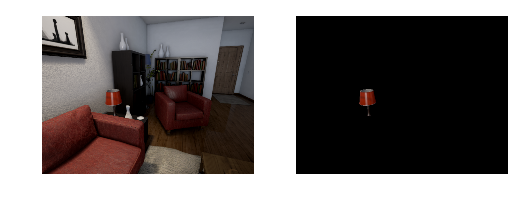

In [23]:
plot_image_with_mask(frame['lit'], dic_instance_mask['SM_DeskLamp_5'])

If we want to plot the region of a category, such as Couch

In [24]:
def get_category_mask(category):
    mask = None
    for obj in image_objects:
        if dic_objects_category[obj] == category:
            if mask is None:
                mask = dic_instance_mask[obj]
            else:
                mask += dic_instance_mask[obj]
    if mask is None:
        print 'Error: the mask is empty'
    return mask


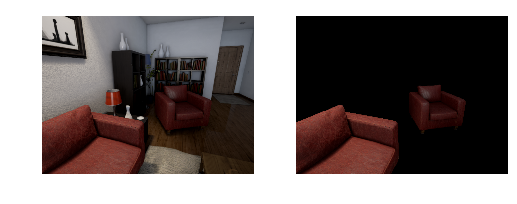

In [25]:
mask = get_category_mask('Couch')
plot_image_with_mask(frame['lit'], mask)

In [26]:
print 'The version of this ipython notebook:'
!git rev-parse --short HEAD
# store the py version of this file for version control
!jupyter nbconvert --to script generate-images.ipynb

The version of this ipython notebook:
b6278f9
[NbConvertApp] Converting notebook generate-images.ipynb to script
[NbConvertApp] Writing 9958 bytes to generate-images.py
